<a href="https://colab.research.google.com/github/SuhuaiChen/CS497-Deep-Learning-for-NLP/blob/main/LSTM(suhuai).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
from google.colab import drive
import multiprocessing
from torch.utils.data import DataLoader
drive.mount('/content/drive')
device = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)

    # map word to ID, count word frequency
    if threshold > -1:
        with open(file_name,'rt') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

In [ ]:
# separate biographies from mix_train, mix_valid, mix_test
def file_to_corpus(fname):
  temp_corpus = []
  with open(fname,'rt') as f:
    for line in f:
      line = line.replace('\n','')
      tokens = line.split(' ')
      for t in tokens:
        try:
          wID = words[t][0]
        except:
          wID = words['<unk>'][0]
        temp_corpus.append(wID)
  return temp_corpus

def corpus_to_list(corpus):
  temp_list = []
  initial = 0
  for i in range(len(corpus)):
    if corpus[i] == words['<start_bio>'][0]:
      initial = i
    if corpus[i] == words['[FAKE]'][0]:
      temp_list.append(corpus[initial+4:i+1])
    if corpus[i] == words['[REAL]'][0]:
      temp_list.append(corpus[initial+5:i+1])
  print(len(temp_list))
  return temp_list

vocab, words, mix_train_corpus = read_encode('/content/drive/MyDrive/cs497/mix.train.txt',[],{},[], 5)

mix_valid_corpus = file_to_corpus('/content/drive/MyDrive/cs497/mix.valid.txt')
mix_test_corpus = file_to_corpus('/content/drive/MyDrive/cs497/mix.test.txt')

bio_list_train = corpus_to_list(mix_train_corpus)
bio_list_valid = corpus_to_list(mix_valid_corpus)
bio_list_test = corpus_to_list(mix_test_corpus)

print(len(bio_list_valid))

7962
986
1052
986


In [ ]:
# construct training and validaion sets
import numpy as np
EMBEDDING_DIM = 600
HIDDEN_DIM = 6

fake_code = words['[FAKE]'][0]
real_code = words['[REAL]'][0]

def list_to_set(bio_list):
  x_temp = []
  y_temp = []
  for bio in bio_list:
    if len(bio) == 0:
      continue
    if bio[-1] == fake_code:
      y_temp.append([0])
    else:
      y_temp.append([1])
    bio = bio[:len(bio)-1]
    while len(bio) < EMBEDDING_DIM:
      bio.append(0)
    x_temp.append(bio[:EMBEDDING_DIM])
  return x_temp, y_temp


x_train, y_train = list_to_set(bio_list_train)

x_valid, y_valid = list_to_set(bio_list_valid)

x_test, y_test = list_to_set(bio_list_test)

print(len(x_valid[8]))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)


print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)



600
(7962, 600)
(7962, 1)
(986, 600)
(986, 1)


In [ ]:
# DataLoaders
train_set = np.concatenate((x_train, y_train), axis=1)
valid_set = np.concatenate((x_valid, y_valid), axis=1)
test_set = np.concatenate((x_test, y_test), axis=1)

BATCH_SIZE = 8
available_workers = multiprocessing.cpu_count()

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, num_workers = available_workers, drop_last=True)
valid_loader = DataLoader(valid_set, batch_size = BATCH_SIZE, num_workers = available_workers, drop_last=True)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, num_workers = available_workers, drop_last=True)


In [ ]:
class LSTM(nn.Module):
    def __init__(self,vocab,words,d_model,d_hidden,n_layers,dropout_rate):
        super().__init__()
        
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.n_layers = n_layers
        self.d_hidden = d_hidden
        self.d_model = d_model
        self.embeds = nn.Embedding(self.vocab_size,d_model)
#          {perform other initializations needed for the LSTM}
        self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTM(input_size=d_model,hidden_size=self.d_hidden, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(d_hidden, 2)
        # self.sig = nn.Sigmoid()
        
    def forward(self,src,h):
        embeds = self.dropout(self.embeds(src))
#          {add code to implement the LSTM}
        lstm_out, h = self.lstm(embeds, h)
        # print("lstm_out: ", lstm_out.shape)
        # lstm_out = lstm_out.contiguous().view(-1, self.d_hidden)
        logits = lstm_out[:,EMBEDDING_DIM-1,:]
        # print("logits: ", logits.shape)
        out = self.fc(logits)
        # print("out: ", out.shape)
        log_probs = F.log_softmax(out, dim=1)
        # log_probs = log_probs.view(BATCH_SIZE, -1)
        # print("log_probs: ", log_probs.shape)
        # log_probs = log_probs[:, -1]
        # print("log_probs: ", log_probs.shape)

        return [log_probs,h]
    
    def init_hidden(self, batch_size):
      weight = next(self.parameters()).data
      hidden = (weight.new(self.n_layers, batch_size, self.d_hidden).zero_().to(device),
              weight.new(self.n_layers, batch_size, self.d_hidden).zero_().to(device))
      return hidden

In [ ]:
# Instantiate model
n_layers = 2
dropout_rate = 0.2

model = LSTM(vocab,words,EMBEDDING_DIM,HIDDEN_DIM,n_layers,dropout_rate).to(device)
print(model)

LSTM(
  (embeds): Embedding(28701, 600)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(600, 6, num_layers=2, batch_first=True)
  (fc): Linear(in_features=6, out_features=2, bias=True)
)


In [ ]:
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc

# helper function to evaluate model on dev and test data
def evaluate(model, criterion, dataloader):
    model.eval()
    losses = []
    pred = []
    h = model.init_hidden(BATCH_SIZE)
    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(dataloader):
            context_tensor = data_tensor[:,0:EMBEDDING_DIM]
            target_tensor = data_tensor[:,EMBEDDING_DIM]
            context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
            log_probs, h = model(context_tensor, h)

            probs = torch.exp(log_probs)
            predicted_label = torch.argmax(probs, dim=1)
            pred.append(predicted_label)
            
            # log_probs = log_probs.squeeze()
            mean_loss += criterion(log_probs, target_tensor).item()
            losses.append(criterion(log_probs, target_tensor).item())

            mean_acc += get_accuracy_from_log_probs(log_probs, target_tensor)
            count += 1

    return mean_acc / count, mean_loss / count, losses, pred

In [ ]:
# train model

lr=0.001
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 4
ounter = 0
print_every = 100
clip=5
train_losses = []

for e in range(epochs):
  st = time.time()
  h = model.init_hidden(BATCH_SIZE)
  for it, data_tensor in enumerate(train_loader): 
    context_tensor = data_tensor[:,0:EMBEDDING_DIM]
    target_tensor = data_tensor[:,EMBEDDING_DIM]
    context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
    h = tuple([each.data for each in h])
    model.zero_grad()    

    # get the output from the model
    #inputs = context_tensor.type(torch.LongTensor)
    log_probs, h = model(context_tensor, h)
    # print(log_probs.shape)
    #log_probs = log_probs.squeeze()
    # print(log_probs.shape)
    #calculate current accuracy
    acc = get_accuracy_from_log_probs(log_probs,target_tensor)

    # calculate the loss and perform backprop
    loss = loss_function(log_probs, target_tensor)
    train_losses.append(loss.item())

    loss.backward()

    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    if it % 100 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}".format(it, e, loss.item(), acc, (time.time()-st)))
            st = time.time()

print("\n--- Evaluating model on dev data ---")
dev_acc, dev_loss, valid_losses, valid_pred = evaluate(model, loss_function, valid_loader)
print("Epoch {} complete! Development Accuracy: {}; Development Loss: {}".format(e, dev_acc, dev_loss))
    

Training Iteration 0 of epoch 0 complete. Loss: 0.7058549523353577; Acc:0.375; Time taken (s): 0.1241903305053711
Training Iteration 100 of epoch 0 complete. Loss: 0.709396481513977; Acc:0.25; Time taken (s): 1.4545795917510986
Training Iteration 200 of epoch 0 complete. Loss: 0.6927329301834106; Acc:0.375; Time taken (s): 1.545060634613037
Training Iteration 300 of epoch 0 complete. Loss: 0.6945019960403442; Acc:0.5; Time taken (s): 1.5542948246002197
Training Iteration 400 of epoch 0 complete. Loss: 0.7322694659233093; Acc:0.375; Time taken (s): 1.3408830165863037
Training Iteration 500 of epoch 0 complete. Loss: 0.6820736527442932; Acc:0.625; Time taken (s): 1.343721628189087
Training Iteration 600 of epoch 0 complete. Loss: 0.6853323578834534; Acc:0.5; Time taken (s): 1.3223800659179688
Training Iteration 700 of epoch 0 complete. Loss: 0.8301563858985901; Acc:0.25; Time taken (s): 1.324026107788086
Training Iteration 800 of epoch 0 complete. Loss: 0.6658412218093872; Acc:0.625; Tim

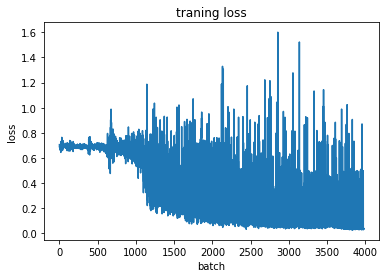

In [ ]:
# plot training losses
import matplotlib.pyplot as plt

x_axis = [i+1 for i in range(3980)]
y_axis = train_losses

plt.plot(x_axis, y_axis)
plt.title('traning loss')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()

[0.03832784667611122, 0.032608456909656525, 0.04294929653406143, 0.42509374022483826, 0.506024956703186, 0.04734669625759125, 0.034620501101017, 0.03922402113676071, 0.03596048429608345, 0.03822851926088333, 0.03920303285121918, 1.1439565420150757, 0.033300116658210754, 0.03252625837922096, 0.03166660666465759, 0.03272170200943947, 0.43114224076271057, 0.7618645429611206, 0.04425695538520813, 0.5035133361816406, 0.0359046533703804, 0.04176059737801552, 0.03530585765838623, 0.035721950232982635, 0.04101002961397171, 0.5045385956764221, 0.03698033466935158, 0.8146916031837463, 0.03823888674378395, 0.4979790449142456, 0.039250750094652176, 0.43980056047439575, 0.031678855419158936, 0.040245555341243744, 0.040996208786964417, 0.03168731555342674, 0.34852495789527893, 0.03548628091812134, 0.03817540407180786, 0.04067619889974594, 0.037052955478429794, 0.4143577516078949, 0.04043010249733925, 0.03950713574886322, 0.047968003898859024, 0.03337725251913071, 0.03704909607768059, 0.0348049253225

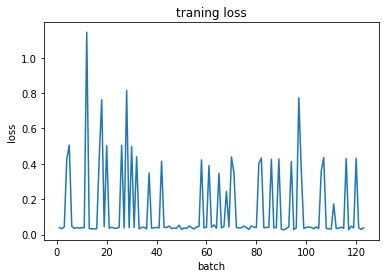

In [ ]:
# plot validation losses
print(valid_losses)
import matplotlib.pyplot as plt

x_axis = [i+1 for i in range(123)]
y_axis = valid_losses

plt.plot(x_axis, y_axis)
plt.title('traning loss')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()

In [ ]:
# evaluating the model with the testing dataset
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import BinaryConfusionMatrix

test_acc, test_loss, test_losses, preds = evaluate(model, loss_function, test_loader)
target = torch.as_tensor(y_test)
print(type(preds))

preds = torch.stack(preds)
preds = torch.flatten(preds).to(device)


target = torch.squeeze(target)
target = target[:1048].to(device)

bcm = BinaryConfusionMatrix().to(device)

print(test_acc)
print(bcm(preds, target))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
<class 'list'>
tensor(0.9656, device='cuda:0')
tensor([[536,   8],
        [ 28, 476]], device='cuda:0')
